In [2]:
from nn_grad import Node
from nn_loss import MinsqrLoss, LogLoss, CrossEntropyLoss
from nn_optimizer import AdamOptim, StochasticOptim
from nn_layer import *
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

In [4]:
data = np.c_[housing.data, housing.target]
columns = np.append(housing.feature_names, ["target"])
dataframe = pd.DataFrame(data, columns=columns)

In [5]:
dataframe.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'target'],
      dtype='object')

In [6]:

dt = dataframe.to_numpy()

In [7]:
x_ = dt[:, 0:8]
y_ = dt[:, 8]

y_ = y_.reshape(len(y_), 1)

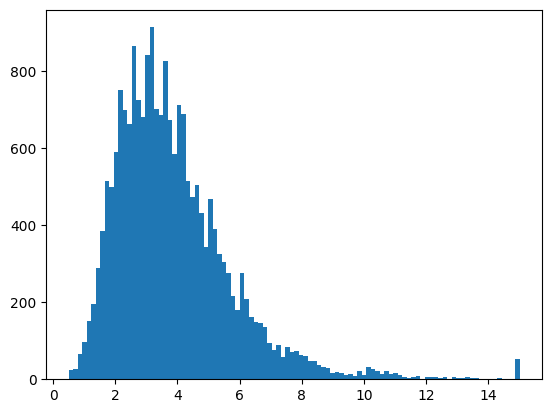

In [8]:

plt.hist(x_[:, 0], bins=100)
plt.show()

In [9]:
dataframe = dataframe.assign(IncomeClass=pd.Series(np.zeros(len(dataframe))).values)

dataframe.loc[dataframe.MedInc < 2, 'IncomeClass'] = 0

dataframe.loc[ (dataframe.MedInc >= 2) &  (dataframe.MedInc < 4), 'IncomeClass'] = 1

dataframe.loc[ (dataframe.MedInc >= 4) &  (dataframe.MedInc < 5), 'IncomeClass'] = 2

dataframe.loc[ (dataframe.MedInc >= 5), 'IncomeClass'] = 3


In [10]:
dataframe.columns


Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'target', 'IncomeClass'],
      dtype='object')

(array([ 960.,    0.,    0., 2517.,    0.,    0.,  682.,    0.,    0.,
         842.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

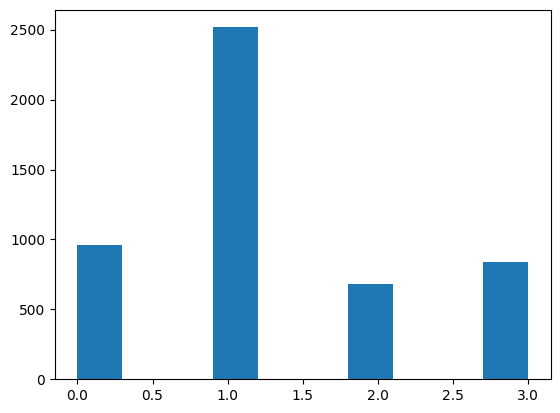

In [11]:
plt.hist(dataframe.loc[0:5000, 'IncomeClass'])

In [12]:
dt = dataframe.loc[0:5000].to_numpy()
x_ = dt[:, 1:9]
y_ = dt[:, 9]

y_ = np.array([[1, 0, 0, 0] if y == 0 else
               [0, 1, 0, 0] if y == 1 else
               [0, 0, 1, 0] if y == 2 else
               [0, 0, 0, 1]
               for y in y_])

In [21]:

x_train, x_test, y_train,y_test = train_test_split(x_, y_, test_size=0.2, shuffle=True)

In [22]:

def train(net, x_train, y_train, x_test, y_test, lr):
    np.seterr(all='ignore')

    indxs = list(range(0, x_train.shape[0]))

    epochs = 10 ** 4 * 5

    optim = AdamOptim(net, lr=lr)

    loss = CrossEntropyLoss()


    acc_scores = []

    f1_scores = []

    loss_scores = []


    arg_train = np.argmax(y_train, 1)

    arg_test = np.argmax(y_test, 1)


    for epoch in range(0, epochs + 1):

        y_train_pred = net.forward(Node(x_train))

        loss_ = loss.backward(y_train_pred, Node(y_train))

        optim.descend()


        if epoch % 10 ** 2 == 0:

            train_loss = loss_.val / y_train.shape[0] / y_train.shape[1]


            print(f'epoch: {epoch} loss value: {train_loss}')


            if epoch % 10 ** 3 == 0:

                y_test_pred = net.forward(Node(x_test))


                test_loss = loss.count_loss(

                    y_test_pred, Node(y_test)).val / y_train.shape[0] / y_train.shape[1]


                train_res = np.argmax(y_train_pred.val, axis=1)

                test_res = np.argmax(y_test_pred.val, axis=1)


                train_acc = accuracy_score(arg_train, train_res)

                test_acc = accuracy_score(arg_test, test_res)


                train_f1 = f1_score(arg_train, train_res, average='macro')

                test_f1 = f1_score(arg_test, test_res, average='macro')


                acc_scores.append([train_acc, test_acc, epoch])

                f1_scores.append([train_f1, test_f1, epoch])

                loss_scores.append([train_loss, test_loss, epoch])


            if train_loss < 10 ** -2:
                break

    return (loss_scores, f1_scores, acc_scores)

In [23]:
def display(loss_scores, f1_scores, acc_scores):
    loss_scores = np.array(loss_scores)
    f1_scores = np.array(f1_scores)
    acc_scores = np.array(acc_scores)

    figure, axis = plt.subplots(1, 3)

    figure.set_figwidth(20)
    figure.set_figheight(10)

    axis[0].set_xlabel('epoch')
    axis[0].set_ylabel('loss')
    axis[0].set_title('Loss score')
    axis[0].plot(loss_scores[:, 2], loss_scores[:, 0],
                 marker='o', label='train')
    axis[0].plot(loss_scores[:, 2], loss_scores[:, 1],
                 marker='o', label='test')
    axis[0].legend()

    axis[1].set_xlabel('epoch')
    axis[1].set_ylabel('accuracy')
    axis[1].set_title('Accuracy score')
    axis[1].plot(acc_scores[:, 2], acc_scores[:, 0], marker='o', label='train')
    axis[1].plot(acc_scores[:, 2], acc_scores[:, 1], marker='o', label='test')
    axis[1].legend()

    axis[2].set_xlabel('epoch')
    axis[2].set_ylabel('f1')
    axis[2].set_title('F1 score')
    axis[2].plot(f1_scores[:, 2], f1_scores[:, 0], marker='o', label='train')
    axis[2].plot(f1_scores[:, 2], f1_scores[:, 1], marker='o', label='test')
    axis[2].legend()
    plt.show()

In [24]:
from nn_layer import nnLayer

from nn_loss import *


class nnImplDot:

    def __init__(self, in_dim, out_dim):

        self.with_bias = True
        self.layers: np.ndarray[nnLayer] = [
            LinearLayer(in_dim, 10, with_bias=self.with_bias, kernel=Node.dot),
            ReluLayer(),
            SigmoidLayer(),
            LinearLayer(10, out_dim, with_bias=self.with_bias, kernel=Node.dot)]

    def forward(self, x_: Node) -> Node:
        for layer in self.layers:
            x_ = layer.forward(x_)
        return x_

In [27]:
net1 = nnImplDot(x_train.shape[1], y_train.shape[1])
stats1 = train(net1, x_train, y_train, x_test, y_test, lr=10**-3)

epoch: 0 loss value: 0.35271341402398343
epoch: 100 loss value: 0.3071377247995226
epoch: 200 loss value: 0.30673061173276434
epoch: 300 loss value: 0.3063649115039317
epoch: 400 loss value: 0.3061194056695239
epoch: 500 loss value: 0.3058077439292886
epoch: 600 loss value: 0.30428889674824117
epoch: 700 loss value: 0.29973327971045977
epoch: 800 loss value: 0.29395313677377344
epoch: 900 loss value: 0.282139096134754
epoch: 1000 loss value: 0.2704367591158491
epoch: 1100 loss value: 0.26030336607323323
epoch: 1200 loss value: 0.25091382904358983
epoch: 1300 loss value: 0.24062107049561046
epoch: 1400 loss value: 0.23356500337145672
epoch: 1500 loss value: 0.22948818616153477
epoch: 1600 loss value: 0.22620478599386165
epoch: 1700 loss value: 0.22319774972696993
epoch: 1800 loss value: 0.22045639664607392
epoch: 1900 loss value: 0.21787663793463577
epoch: 2000 loss value: 0.21543772459917057
epoch: 2100 loss value: 0.21326120520170427
epoch: 2200 loss value: 0.21097188168552505
epoch: 

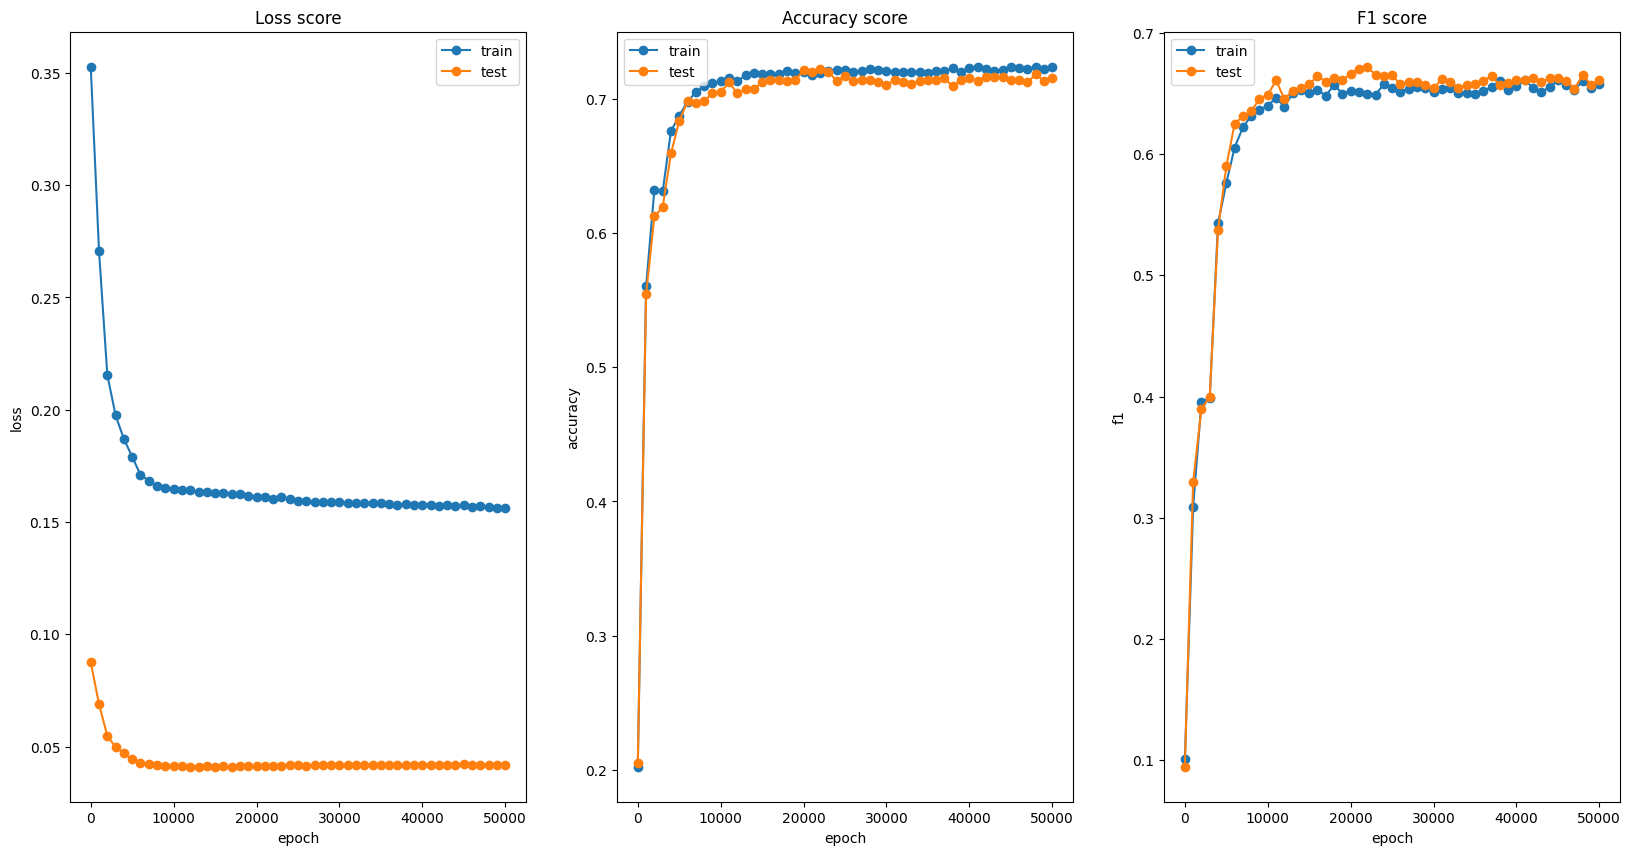

In [28]:
display(*stats1)

In [33]:
from nn_layer import nnLayer

from nn_loss import *


class nnImplGauss:

    def __init__(self, in_dim, out_dim):
        self.with_bias = True
        self.layers: np.ndarray[nnLayer] = [
            LinearLayer(in_dim, 16, with_bias=self.with_bias, kernel=Node.gauss),
            ReluLayer(),
            SigmoidLayer(),
            LinearLayer(16, 12, with_bias=self.with_bias, kernel=Node.gauss),
            LinearLayer(12, out_dim, with_bias=self.with_bias, kernel=Node.gauss),
            ]

    def forward(self, x_: Node) -> Node:
        for layer in self.layers:
            x_ = layer.forward(x_)
        return x_

In [35]:
net2 = nnImplGauss(x_train.shape[1], y_train.shape[1])
stats2 = train(net2, x_train, y_train, x_test, y_test, lr=10**-4 * 5)

epoch: 0 loss value: 1.3088900849282528
epoch: 100 loss value: 0.30844277439893736
epoch: 200 loss value: 0.3074219016112302
epoch: 300 loss value: 0.30732633480681654
epoch: 400 loss value: 0.3071484863352842
epoch: 500 loss value: 0.3070062526477255
epoch: 600 loss value: 0.30683200107290576
epoch: 700 loss value: 0.30665420406690996
epoch: 800 loss value: 0.3064203339135851
epoch: 900 loss value: 0.3054243347176421
epoch: 1000 loss value: 0.30474225910490044
epoch: 1100 loss value: 0.3040739989010494
epoch: 1200 loss value: 0.303431313535243
epoch: 1300 loss value: 0.302867013434872
epoch: 1400 loss value: 0.30239473791151844
epoch: 1500 loss value: 0.30201425130997334
epoch: 1600 loss value: 0.30170407106135383
epoch: 1700 loss value: 0.30144613608577925
epoch: 1800 loss value: 0.30122902974457383
epoch: 1900 loss value: 0.3009632781445471
epoch: 2000 loss value: 0.3007934337910202
epoch: 2100 loss value: 0.300652097092781
epoch: 2200 loss value: 0.3005268866808931
epoch: 2300 loss

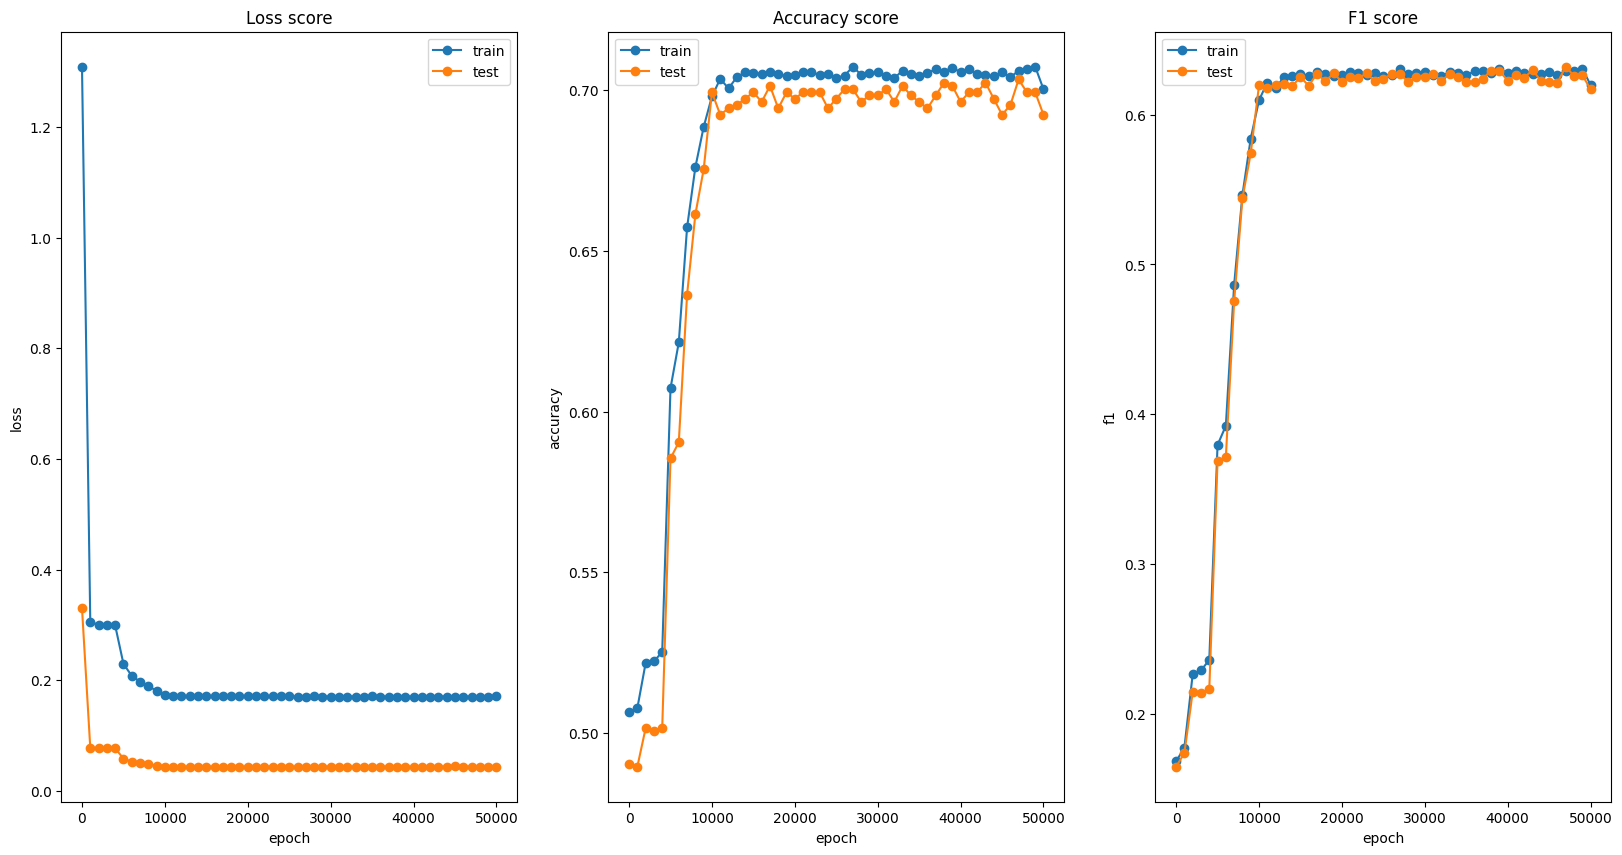

In [36]:
display(*stats2)

In [52]:
from nn_layer import nnLayer

from nn_loss import *


class nnImplMixed:

    def __init__(self, in_dim, out_dim):

        self.with_bias = True
        self.layers: np.ndarray[nnLayer] = [
            LinearLayer(in_dim, 15, with_bias=self.with_bias, kernel=Node.dot),
            SigmoidLayer(),
            LinearLayer(15, 8, with_bias=self.with_bias, kernel=Node.gauss),
            LinearLayer(8, out_dim, with_bias=self.with_bias, kernel=Node.dot),
            ]

    def forward(self, x_: Node) -> Node:
        for layer in self.layers:
            x_ = layer.forward(x_)
        return x_


In [55]:
net3 = nnImplMixed(x_train.shape[1], y_train.shape[1])
stats3 = train(net3, x_train, y_train, x_test, y_test, lr=10**-4)

epoch: 0 loss value: 2.133216081096848
epoch: 100 loss value: 1.6224251959005038
epoch: 200 loss value: 1.2883641264997114
epoch: 300 loss value: 1.0181459152815862
epoch: 400 loss value: 0.788402755259336
epoch: 500 loss value: 0.6079042079911845
epoch: 600 loss value: 0.453372929004807
epoch: 700 loss value: 0.34770678839137903
epoch: 800 loss value: 0.3142055505626837
epoch: 900 loss value: 0.3083905355104865
epoch: 1000 loss value: 0.3078354704293476
epoch: 1100 loss value: 0.30774505407057356
epoch: 1200 loss value: 0.3076727327338677
epoch: 1300 loss value: 0.3075895239557303
epoch: 1400 loss value: 0.30748206308465414
epoch: 1500 loss value: 0.30735531054438386
epoch: 1600 loss value: 0.3072141934023814
epoch: 1700 loss value: 0.3070595876187005
epoch: 1800 loss value: 0.30690251121752543
epoch: 1900 loss value: 0.3067523249813939
epoch: 2000 loss value: 0.3066101870401246
epoch: 2100 loss value: 0.3064727835230571
epoch: 2200 loss value: 0.3063413001954035
epoch: 2300 loss valu

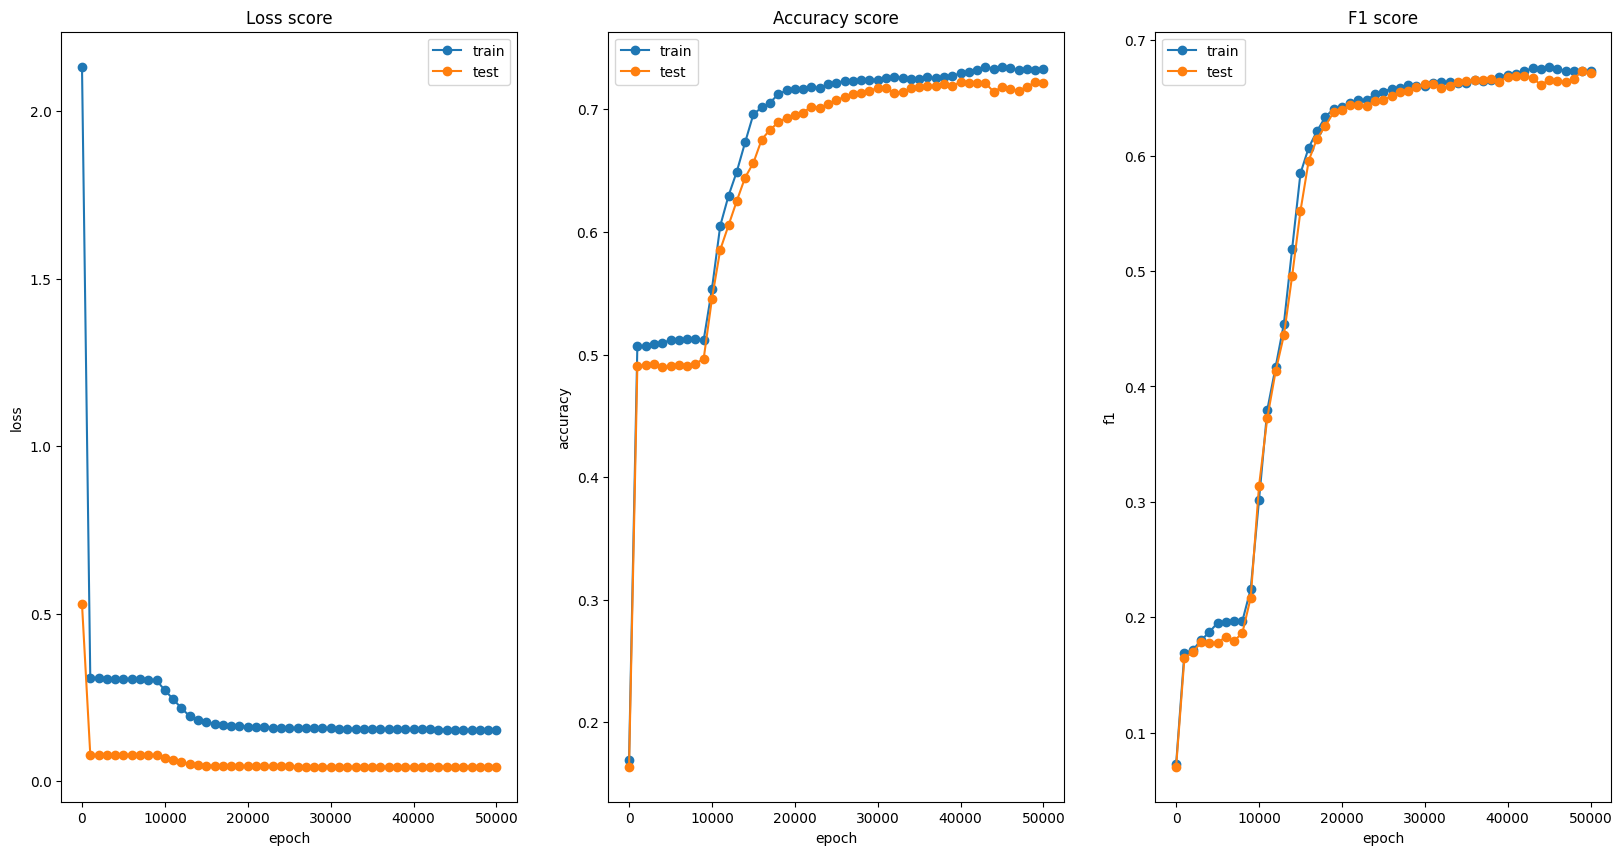

In [56]:
display(*stats3)